# disclaimer
this is a code almost entirely copied from https://jcrist.github.io/dask-sklearn-part-3.html. The goal of this exercise is slighly different. We want to understand:

1. how much computational power we will need for processing all 22 csv files that is ~11.5 GB in total. Do we really need 4 `m3.2 large` instances (with 8 cores, 30 GB RAM) each?
2. what is the most amount of data that we can successfully process for a single node Xeon machine using Dask and Scikit-learn?

In [1]:
%matplotlib inline

In [2]:
import dask
import dask.dataframe as ddf
import numpy as np 
import os
import matplotlib.pyplot as plt
import dask_searchcv as dcv

In [3]:
from distributed import Executor, Client, LocalCluster, progress

this means that we will have 4 processes, each process can use two threads.
Additionally, there will be one more python process running as the scheduler. You can find this out using `ps ax | grep python`

we are just using a single Xeon processor

In [4]:
n_workers = 11
ncores = 2 

In [5]:
!cat /proc/cpuinfo | grep 'Xeon' | head -1

model name	: Intel(R) Xeon(R) CPU E5-2699 v4 @ 2.20GHz
grep: write error: Broken pipe


In [6]:
cluster = LocalCluster(n_workers=n_workers, threads_per_worker=ncores)

In [7]:
client = Client(cluster)

In [8]:
client

Client Scheduler: tcp://127.0.0.1:41109 Dashboard: http://127.0.0.1:8787,Cluster Workers: 11 Cores: 22 Memory: 10.09 GB


In [9]:
exc = Executor(cluster)

In [10]:
!ls ../data/*.csv | wc -l

352


we are only using 1 node vs 4 `AWS m1.large` nodes in the example

there are nans for some of the columns so we cannot represent them as integers. Otherwise the nans will not be processed correctly.

See https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236&DB_Short_Name=On-Time for available fields

In [11]:
categorical_cols = {
    'Origin': np.str,
    'Dest': np.str,
    'UniqueCarrier': np.str
}

In [12]:
cols = {'Year': np.float16,
        'Month': np.float16,
        'DayofMonth': np.float16,
        'DayOfWeek': np.float16,
        'DepTime': np.float16,
        'ArrTime': np.float16,
        'FlightNum': np.float16,
        # 'TailNum': np.int32 # number of a specific 
        'ActualElapsedTime': np.float16,
        'ArrDelay': np.float16,
        'DepDelay': np.float16,
        'Origin': np.str,
        'Dest': np.str,
        'UniqueCarrier': np.str,
        'Distance': np.float16, 
        'TaxiIn': np.float16,
        'TaxiOut': np.float16,
        'Cancelled': np.float16,
        'Diverted': np.float16,
        }

In [13]:
data_dir = "../data/"

In [14]:
filelist = [data_dir + str(year) + "_" + str(month) + ".csv" 
            for year in range(1988, 1989)
            for month in range(1, 12)
           ]

In [15]:
df = ddf.read_csv(filelist,
                  blocksize=int(128e6), 
                  usecols=list(cols.keys())
                  )

In [16]:
exc.persist(df)

,Year,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,Origin,Dest,DepTime,DepDelay,TaxiOut,TaxiIn,ArrTime,ArrDelay,Cancelled,Diverted,ActualElapsedTime,Distance
npartitions=22,,,,,,,,,,,,,,,,,,
None,int64,int64,int64,int64,object,int64,object,object,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
None,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [17]:
progress(df, notebook=False)

[########################################] | 100% Completed |  0.0s

In [18]:
def getGroupBy(df):
    aggregations = (df.groupby('Year').ArrDelay.mean(),
                df.groupby('Month').ArrDelay.mean(),
                df.groupby('UniqueCarrier').ArrDelay.mean()
               )
    (delaytime_by_year, 
     delayedtime_by_month, 
     delayedtime_by_Carrier) = dask.compute(*aggregations)
    return delaytime_by_year, delayedtime_by_month, delayedtime_by_Carrier

In [19]:
%time delaytime_by_year, delayedtime_by_month, delayedtime_by_Carrier = getGroupBy(df)

CPU times: user 607 ms, sys: 84.3 ms, total: 692 ms
Wall time: 2.21 s


In [20]:
dask.compute(df.size)

(85745556,)

In [21]:
len(df)

4763642

In [22]:
delaytime_by_year

Year
1988    6.392125
Name: ArrDelay, dtype: float64

there are some flights that are cancelled or diverted, 
or do not have a ArrDelay time 

In [23]:
len(df)

4763642

In [24]:
def mapDelayTime(time):
    """
    transform delay time into 5 categories
    """
    if time == 0.0:  # on time 
        return 0
    elif time > 0.0 and time < 15:  # a bit late 
        return 1 
    elif time > 15:  # very late 
        return 2
    elif time < 0 and time > -15:  # early 
        return -1
    elif time < -15:  # very early
        return -2
    else:
        return np.nan

In [25]:
df = df.assign(delayed=(df.ArrDelay.map(mapDelayTime))
              ).dropna(subset=["delayed"])

In [26]:
len(df)

4604425

In [27]:
dask.compute(df.delayed.describe())

(count    4.604425e+06
 mean     2.690321e-01
 std      1.234328e+00
 min     -2.000000e+00
 25%     -1.000000e+00
 50%      1.000000e+00
 75%      2.000000e+00
 max      2.000000e+00
 dtype: float64,)

# simple EDA 

In [28]:
counts = dask.compute(df.groupby("UniqueCarrier").count())

In [29]:
uniqueCarrier_count = counts[0].Year

In [30]:
uniqueCarrier_count.values

array([611169,  79836, 403005, 343204, 162064, 376909,  62941, 417584,
        40714, 244292, 519659, 435972, 235061, 672015])

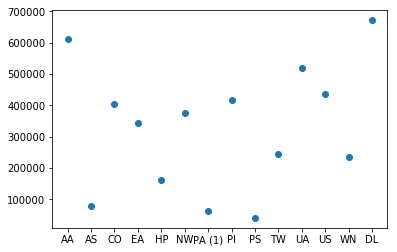

In [31]:
plt.plot(range(len(uniqueCarrier_count)), 
               uniqueCarrier_count.values, 'o')
_ = plt.xticks(range(len(uniqueCarrier_count)), 
           list(uniqueCarrier_count.index))

In [32]:
dask.compute(df.Cancelled.describe())

(count    4604425.0
 mean           0.0
 std            0.0
 min            0.0
 25%            0.0
 50%            0.0
 75%            0.0
 max            0.0
 dtype: float64,)

In [33]:
dask.compute(df.Diverted.describe())

(count    4604425.0
 mean           0.0
 std            0.0
 min            0.0
 25%            0.0
 50%            0.0
 75%            0.0
 max            0.0
 dtype: float64,)

In [34]:
dask.compute(df[['DepDelay', 'ArrDelay']].corr())

(          DepDelay  ArrDelay
 DepDelay  1.000000  0.810189
 ArrDelay  0.810189  1.000000,)

even though `DepDelay` is highly correlated with `ArrDelay` it doesn't have a near-perfect correlation

# standardizer and whitening the data

depending on what ML algorithm standardizing the features can help. Not really in the case of Random forest.

# collect a training and test set from a stratified sampling scheme

In [35]:
from dask_searchcv.model_selection import Pipeline, StratifiedKFold

we are just splitting the data in 3 sets 

In [36]:
skf = StratifiedKFold(n_splits=3, shuffle=True)

# only specific algorithms would require categorical variables to be one-hot encoded 

we will not do any one-hot encoding because it is not helpful for some ML algorithms such as random forest. It is very memory intensive and is only useful for distance-based classification algorithms like K-means.

In [37]:
x_cols = ['Year', 'Month', 'DayofMonth', 'DayOfWeek', 'UniqueCarrier',
          'FlightNum', 'Origin', 'Dest', 'DepTime', 'DepDelay',
          'TaxiOut', 'TaxiIn', 'ArrTime', 'ActualElapsedTime', 'Distance']

In [38]:
y_col = ['delayed']

In [39]:
X, y = df[x_cols], df[y_col]

In [40]:
%time train, test = skf.split(X, y)

IndexError: too many indices for array

# come up with Pipeline algorithms 

In [ ]:
Pipeline()

In [ ]:
dask.dataframe.

In [ ]:
Pipeline()